# estimation error

Provided the VC-dimension is finite, Theorem 9 gives a generalisation error of the form

$$
L_{\mathcal D}(h_S)=\inf_{h\in\mathcal H} L_{\mathcal D}(h) + \mathcal O\left(\sqrt{1/m}\right)
$$

Let's check whether we can verify that the estimation error drops with $\sqrt{1/m}$.

In [11]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")   # for nicer plots
from sklearn.utils import shuffle
from sklearn.metrics import zero_one_loss
import math
from sklearn.linear_model import LinearRegression

We take MNIST again as test case. For a more robust validation we should probably perform this for a number of different datasets. We fetch the data set.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
X, y = mnist["data"], mnist["target"]

Let's split the data into training and test set. 

In [3]:
training_size=45000
X, y = sklearn.utils.shuffle(X,y)
X_train, X_test, y_train, y_test = X[:training_size], X[training_size:], y[:training_size], y[training_size:]
X_train.shape, X_test.shape

((45000, 784), (25000, 784))

We compute training and test errors for varying training set sizes. For fixed training set size we repeat the fit a number of times (parameter repeats) to gain a bit of statistical stability. The parameter repeats should probably set to something larger than 10, but as it is the method already takes a while to complete. 

In [9]:
def errors(classifier,step_size,repeats=10):
    sizes=np.arange(1000,len(y_train),step_size)
    train_error=np.zeros((len(sizes),repeats))
    test_error=np.zeros((len(sizes),repeats))
    for i,s in enumerate(sizes):
        for j in range(repeats):
            XX,yy=sklearn.utils.resample(X_train,y_train,n_samples=s,replace=False)  ## randomly select X,y for training of size s
            classifier.fit(XX,yy)
            train_error[i,j]=zero_one_loss(yy,classifier.predict(XX))
            test_error[i,j]=zero_one_loss(y_test,classifier.predict(X_test))
    return sizes,train_error,test_error

Somewhat arbitrarily we fix the maximum depth of the decision tree to 10. We need to fix it to some not too large value as decision trees of unbounded depth have unbounded VC-dimension.

In [10]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth=10)
sizes,train_error,test_error=errors(tree,1000,repeats=10) # this takes a while...

We plot the means of training and test error against the training set size.

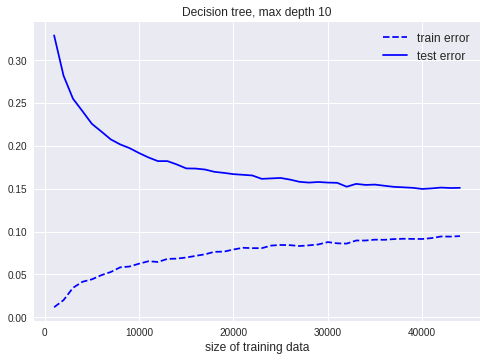

In [25]:
_,ax=plt.subplots()
ax.plot(sizes,train_error.mean(axis=1),"b--", label="train error")
ax.plot(sizes,test_error.mean(axis=1),"b-", label="test error")
ax.set_xlabel("size of training data", fontsize=12)
ax.legend(loc="upper right", fontsize=12)
ax.set_title("Decision tree, max depth 10",fontsize=12)
plt.show()

The plot already seems to suggest that the test error (our stand-in for the generalisation error) drops with $\sqrt(1/m)$. To verify this we do a fit. That is, we look for the numbers $a,b$ such that the function $m\mapsto a+b/\sqrt(m)$ fits the test error best. Fortunately, we can use linear regression here, if we transform the training set sizes to $m\mapsto \sqrt(1/m)$.

In [15]:
xx=np.array([math.sqrt(1/m) for m in sizes])
xx=xx.reshape((-1,1))
lin_reg=LinearRegression()
lin_reg.fit(xx,test_error.mean(axis=1))
a,b=lin_reg.intercept_,*lin_reg.coef_
a,b

(0.11644157356539607, 7.248490081068027)

Note that the "intercept" $a$ has an interesting interpretation here. If the fit really models the generalisation error then $a$ should correspond to the approximation error. In this case that would mean that no decision tree of maximum depth 10 can obtain a better generalisation error than 13%.

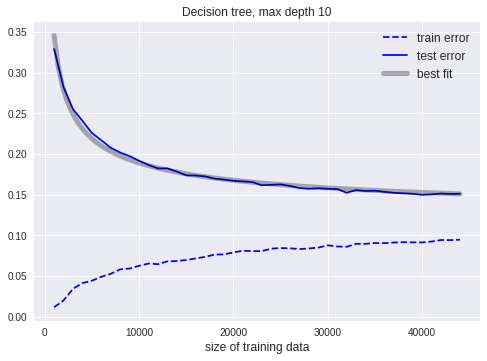

In [24]:
_,ax=plt.subplots()
ax.plot(sizes,train_error.mean(axis=1),"b--", label="train error")
ax.plot(sizes,test_error.mean(axis=1),"b-", label="test error")
ax.set_xlabel("size of training data", fontsize=12)
ax.set_title("Decision tree, max depth 10",fontsize=12)

s=np.linspace(sizes[0],sizes[-1],100)
ax.plot(s,[a+b/math.sqrt(m) for m in s],'k',label='best fit',alpha=0.3,linewidth=5)
ax.legend(loc="upper right", fontsize=12)
plt.savefig('est_err.png',dpi=300)
plt.show()

The fit is quite good. We conclude that the estimation error indeed drops with roughly $\sqrt(1/m)$.